In [49]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import functools
import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from math import sqrt
import pandas as pd
from shapely.ops import cascaded_union
pd.set_option('precision', 10)
%matplotlib inline

In [45]:
import networkx as nx

worDirectory = "C:/Users/g_filo01/Desktop/Street_Network_Excercise/"
# iface.addVectorLayer(worDirectory+"London_sn.shp","", "ogr")

G = nx.read_shp(worDirectory+"London_sn.shp")
pos = {ix: coords for ix, coords in enumerate(G.nodes())}
posInv = {coords: ix for ix, coords in enumerate(G.nodes())}

In [46]:
Ng = nx.Graph() #Empty graph
Ng = Ng.to_undirected()
Ng.add_nodes_from(pos.keys())

In [47]:
for i, item in enumerate(G.edges()):
    indexN1 = posInv[item[0]] #extracting nodeID of node1 from coordinates
    indexN2 = posInv[item[1]] #extracting nodeID of node2 from coordinates
    
    #adding edge to the new clean network exporting edge attributes 
    Ng.add_edge(indexN1, indexN2)
    Ng[indexN1][indexN2]['length'] = G[item[0]][item[1]]['length']  
    Ng[indexN1][indexN2]['streetID']= G[item[0]][item[1]]['streetID'] 

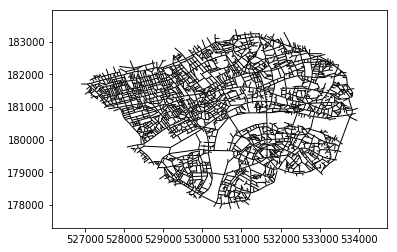

In [28]:
nx.draw_networkx_edges(Ng, pos)

In [48]:
Ng.node[1]

{}

In [ ]:
Bc = nx.betweenness_centrality(Ng, k=None, weight = 'length', normalized=False)

In [ ]:
Cc = nx.closeness_centrality(Ng, k=None, weight = 'length', normalized=False)

## Centrality measures

In [34]:
def nodes_dict(G):
    nodes_list = G.nodes()
    look = {}

    for i, item in enumerate(nodes_list):
        cod = item
        x = nodes_list[item]['x']
        y = nodes_list[item]['y']
        look[cod] = (x,y)
    
    return look


def euclidean_distance(xs, ys, xt, yt):
    """ xs stands for x source and xt for x target """
    return sqrt((xs - xt)**2 + (ys - yt)**2)

In [31]:
def straightness_centrality(G, weight, normalized=True):

    path_length = functools.partial(nx.single_source_dijkstra_path_length, weight=weight)

    nodes = G.nodes()
    straightness_centrality = {}

    # Initialize dictionary containing all the node id and coordinates
    # coord_nodes = get_nodes_coords(Node, Session)
    coord_nodes = nodes_dict(G)

    for n in nodes:
        straightness = 0
        sp = path_length(G,n)

        if len(sp) > 0 and len(G) > 1:
            # start computing the sum of euclidean distances

            for target in sp:
                if n != target and target in coord_nodes:
                    network_dist = sp[target]
                    euclidean_dist = euclidean_distance(*coord_nodes[n]+coord_nodes[target])
                    straightness = straightness + (euclidean_dist/network_dist)

            straightness_centrality[n]= straightness
               
            if normalized:
                straightness_centrality[n] = straightness * (1.0/(len(G)-1.0) )

        else:
            straightness_centrality[n]=0.0

    return straightness_centrality

In [41]:
Sc = straightness_centrality(Ng, 'length', normalized=False) #dijkstra_path_length reads nested weights

In [42]:
def to_df(list_dict, list_col):
    
    df = pd.DataFrame(list_dict).T
    df.columns = ['d{}'.format(i) for i, col in enumerate(df, 1)]
    df.columns = list_col
    
    return(df)

In [43]:
nodes_df = to_df([Bc, Bs], ["Cb", "Cs"])

In [44]:
nodes_df.head()

,Cb,Cs
101986,189399.1425031235,11006.9277933151
101990,215558.3790408004,11033.2872711719
101991,116711.6825505181,10995.1499468915
101992,308279.5612744110,11006.6957360565
101993,817874.9997177857,11049.1602424829


In [45]:
nodes_tmp = pd.merge(nodes_small, nodes_df, left_on="nodeID", right_index = True, how='left')

In [30]:
# POI = gpd.read_file('Outputs/POI.shp')
POI = gpd.read_file(folder_ouptut+'/POI_'+city_name+'.shp')

In [31]:
POI = POI.to_crs(epsg=epsg)

## Reach centrality and local Cb

In [32]:
for row in nodes_tmp.itertuples():

    g = row[3] #geometry
    fil = g.buffer(50)
    
    sindex = POI.sindex
    possible_matches_index = list(sindex.intersection(fil.bounds))
    possible_matches = POI.iloc[possible_matches_index]
    
    
    weight = len(possible_matches)
    nodes_tmp.set_value(row[0], 'weight', weight)

In [33]:
nodes_tmp.gdf_name = "weighted"

In [34]:
for n in Ng.nodes():
    Ng.node[n]['weight'] = nodes_tmp['weight'].loc[n]

In [35]:
def reach(G, weight, radius, normalized=True):
  
    path_length = functools.partial(nx.single_source_dijkstra_path_length, weight=weight)

    nodes = G.nodes()
    reach_centrality = {}
    coord_nodes = nodes_dict(G)

    for n in nodes:
        reach = 0
        sp = path_length(G,n)
        sp_radium = dict((k, v) for k, v in sp.items() if v <= radius)
        
        if len(sp_radium) > 0 and len(G) > 1:
            
            for target in sp_radium:
                if n != target and target in coord_nodes:
                    weight_target = G.node[target]['weight']
                    reach = reach + weight_target
                        

            reach_centrality[n] = reach

        else:               
            reach_centrality[n]=0.0

    return reach_centrality

In [36]:
# different radius
# Rc400 = reach(Ng, 'length', radius=400, normalized=False) #dijkstra_path_length reads nested weights
Rc600 = reach(Ng, 'length', radius=600, normalized=False) #dijkstra_path_length reads nested weights

In [37]:
def local_CB(G, w, radius, distance=True):

    if distance is True:
        weight=w
        
    path_length = functools.partial(nx.single_source_dijkstra_path_length, weight=weight)

    nodes = G.nodes()
    cb = {}
    coord_nodes = nodes_dict(G)

    for obj in nodes:
        sp = path_length(G,obj)
        sp_radium = dict((k, v) for k, v in sp.items() if v <= radius)

        to_keep = list(sp_radium.keys())

        G_small = nx.Graph(G.subgraph(to_keep))
        
        be = nx.betweenness_centrality(G_small, k=None, weight = 'length', normalized=False)
        cb[obj] = be[obj]
     
    return cb

In [38]:
Bc600 = local_CB(Ng, 'length', radius=600, distance = True) #dijkstra_path_length reads nested weights
# Bc800 = local_CB(Ng,'length', radius=800, distance = True) #dijkstra_path_length reads nested weights

In [44]:
indexes_df = to_df([Rc600, Bc600], ["Rc600","Bc600"])

In [45]:
nodes = pd.merge(nodes_tmp, indexes_df, left_on="nodeID", right_index = True, how='left')

In [52]:
def scaling(df, i):
    df[i+'_sc'] = (df[i]-df[i].min())/(df[i].max()-df[i].min())

In [53]:
lr = gpd.read_file("C:/Users/g_filo01/sciebo/Projects/landmarks")

In [57]:
lr

,BUILD_ID,visual,structural,cultural,pragmatic,score,score_scal,localScore,localSV,localSV2,geometry,localSV_sc,localSV2_sc
0,41263,0.1380687115,0.1015720552,0.2,0.4361685585,0.1631228282,0.2016282268,0.45,0.45,0.55,"POLYGON ((236271.87767054 900600.0988056338, 2...",0.6415094340,1.0000000000
1,41138,0.1015898408,0.1067121893,0.0,0.3112406756,0.1139326447,0.1234320054,0.24,0.34,0.24,"POLYGON ((236335.9718005408 900772.8433656292,...",0.4339622642,0.2954545455
2,41058,0.0530761384,0.0823040742,0.2,0.4858987428,0.1198191657,0.1327896387,0.54,0.64,0.54,"POLYGON ((236292.5077505403 900754.7075456283,...",1.0000000000,0.9772727273
3,40205,0.3651396265,0.0892151518,0.2,0.4587155963,0.2752059184,0.3798034954,0.11,0.11,0.11,"POLYGON ((236247.5808205398 900752.4214056333,...",0.0000000000,0.0000000000


In [56]:
scaling(lr, "localSV")
scaling(lr, "localSV2")

In [47]:
col = ['Bc', 'Sc', 'Rc600', 'Bc600']

for i in col:
    scaling(nodes, i)

In [48]:
nodes.head()

,x,y,geometry,nodeID,Cb,Cs,Ci,weight,Cr_400,Cr_600,...,Cb_800,Cb_scaled,Cb_std,Cs_scaled,Cs_std,Cr_400_scaled,Cr_400_std,Cb_600_scaled,Cb_600_std,MCA
0,529767.0000001178,181173.9999995434,POINT (529767.0000001178 181173.9999995434),0,24425.0,3120.9748873607,0.0044862705,70.0,2664.0,7278.0,...,1352.0,0.0194867155,-0.4295539204,0.7429054505,0.2339684293,0.4463059139,1.2344785301,0.1336083214,-0.0819151786,0.3020660508
1,532289.0800001298,182423.6899994875,POINT (532289.0800001298 182423.6899994875),1,4000.0,3181.4789456433,0.0035892507,6.0,871.0,1833.0,...,935.0,0.0031912738,-0.5980834761,0.8214265455,0.9024245041,0.1459205897,-0.3786503257,0.1020444763,-0.2987480062,0.1303962947
2,531336.0000001253,180096.9999995109,POINT (531336.0000001253 180096.9999995109),2,52854.0,3039.7841641378,0.0043940078,6.0,643.0,1327.0,...,812.0,0.0421678961,-0.1949822318,0.6375375682,-0.6630363948,0.1077232367,-0.5837776984,0.0835724534,-0.4256444904,0.1011190760
3,530201.0000001198,181209.9999995350,POINT (530201.0000001198 181209.999999535),3,425069.0,3172.7245591324,0.0048351233,37.0,3184.0,7005.0,...,2258.0,0.3391278887,2.8762162306,0.8100652577,0.8057049946,0.5334226839,1.7023128887,0.2152080344,0.4786469607,0.3936211191
4,533437.1500001356,181216.5099994599,POINT (533437.1500001356 181216.5099994599),4,0.0,3176.4033371200,0.0027342076,22.0,934.0,2947.0,...,0.0,0.0000000000,-0.6310880403,0.8148395106,0.8463485739,0.1564751215,-0.3219703938,0.0000000000,-0.9997586815,0.0830254684


In [49]:
nodes.crs = crs
nodes['height'] = 2

In [51]:
nodes.to_file(folder_ouptut+city_name+'_nodes.shp', driver='ESRI Shapefile')

# Paths

In [52]:
Eb = nx.edge_betweenness_centrality(Ng, weight='length', normalized=False)

In [53]:
edge_id={}
for i, g in Ng.edges(): edge_id[(i,g)]=Ng[i][g]['streetID']

edges_df = to_df([Eb, edge_id], ["Eb", "streetID"])
edges_df.streetID = edges_df.streetID.astype(int)

In [54]:
paths_tmp = pd.merge(edges_small, edges_df, left_on = 'streetID', right_on = 'streetID', how='left')

# Dual Analysis

In [55]:
# centroids for dual analysis

def getting_cn(streets_gdf):
    
    centroids_gdf = streets_gdf.copy()
    centroids_gdf['centroid'] = gpd.GeoSeries(centroids_gdf['geometry'].centroid)
    centroids_gdf['intersecting'] = "NaN"
    centroids_gdf['intersecting'] = centroids_gdf['intersecting'].astype(object)
    
    return(centroids_gdf)

centroids_small = getting_cn(edges_small)
# centroids_large = getting_cn(edges_large)

In [58]:
centroids_small.head()

,geometry,streetID,u,v,key,distance,centroid,intersecting
0,LINESTRING (528421.0000001118 180948.999999571...,0,886,199,0,90.7584444386,POINT (528448.9147123025 180970.8538257579),NaN
1,LINESTRING (533740.0500001372 181263.939999453...,1,2718,1085,0,307.5254896358,POINT (533787.1696836202 181119.9464193996),NaN
2,LINESTRING (533835.3200001377 180907.189999451...,2,1861,1534,0,131.1818512142,POINT (533836.4036256567 180842.4056228355),NaN
3,LINESTRING (528136.0000001106 180780.999999577...,3,3213,3486,0,148.7149451569,POINT (528206.3074209788 180805.1229684248),NaN
4,LINESTRING (532764.1500001322 180312.289999477...,4,3698,875,0,261.7112357594,POINT (532889.7397718716 180278.3508118218),NaN


In [59]:
#find_intersecting

def find_intersecting(centroids_gdf):
    
    processed = []    
    for e in centroids_gdf.itertuples():
        intersections = []
        
        from_node = e[3] #check before running the right column of "u" and "v"
        to_node = e[4]
    
        tmp = centroids_gdf.loc[(centroids_gdf['u'] == from_node) |
                        (centroids_gdf['u'] == to_node) |
                        (centroids_gdf['v'] == to_node) |
                        (centroids_gdf['v'] == from_node)]

        for l in tmp.itertuples():
            if ((e[0]==l[0]) | ((e[0], l[0]) in processed) | ((l[0], e[0]) in processed)): continue
        
            else:
                intersections.append(l[2])  #appending streetID
                processed.append((l[0],e[0]))
    
        centroids_gdf.set_value(e[0],'intersecting', intersections)
    
    return(centroids_gdf)

centroids_small = find_intersecting(centroids_small)
# centroids_large = find_intersecting(centroids_large)

In [60]:
#creating nodes representing street segments

def dual_nodes(centroids_gdf):

    centroids_data = centroids_gdf[['streetID', 'intersecting', 'length']]
    geometry = centroids_gdf['centroid']
    
    nodes_dual = gpd.GeoDataFrame(centroids_data, crs=crs, geometry=geometry)
    nodes_dual['x'] = [x.coords.xy[0][0] for x in centroids_gdf['centroid']]
    nodes_dual['y'] = [y.coords.xy[1][0] for y in centroids_gdf['centroid']]
    
    return(nodes_dual)

nodesDual_small = dual_nodes(centroids_small)
# nodesDual_large = dual_nodes(centroids_large)

In [61]:
def dual_edges(nodes_dual, centroids_gdf):

    edges_dual = pd.DataFrame(columns=['u','v', 'key', 'geometry', 'length'])

    for row in nodes_dual.itertuples():
        
        obj_id = row[1] #streetID of the relative segment
        length = row[3]

        for i in list(row[2]): #intersecting segments
            # i is the streetID
            index = centroids_gdf.index[centroids_gdf.streetID==i].tolist()[0]
            length_v =  centroids_gdf['length'][centroids_gdf.streetID==i][index]
            distance = (length+length_v)/2
        
            # adding a row with u-v, key fixed as 0, Linestring geometry 
            # from the first centroid to centroid intersecting segment 
        
            edges_dual.loc[-1] = [obj_id, i, 0,  
                                LineString([row[4], nodes_dual.loc[index]['geometry']]),
                                distance] 
          
            edges_dual.index = edges_dual.index + 1
            
    edges_dual = edges_dual.sort_index(axis=0)
    geometry = edges_dual['geometry']
    edges_dual = gpd.GeoDataFrame(edges_dual[['u','v', 'key', 'length']], crs=crs, geometry=geometry)
    
    return(edges_dual)

edgesDual_small = dual_edges(nodesDual_small, centroids_small)
# edgesDual_large = dual_edges(nodesDual_large, centroids_large)

In [62]:
#computing angles

def finding_angles(edges_dual, edges, nodes):
    
    for row in edges_dual.itertuples():

        #retrieveing original lines from/to
    
        from_node = nodes.loc[edges['u'].loc[edges.streetID==row[1]]].index.tolist()[0]
        to_node = nodes.loc[edges['v'].loc[edges.streetID==row[1]]].index.tolist()[0]
                                            
        from_node2 = nodes.loc[edges['u'].loc[edges.streetID==row[2]]].index.tolist()[0]           
        to_node2 = nodes.loc[edges['v'].loc[edges.streetID==row[2]]].index.tolist()[0]
    
        if ((from_node == from_node2) & (to_node == to_node2) |
            (from_node == to_node2) & (to_node == from_node2)):
            
            deflection = 0
            deflection_rad=0
    
        else:
         
            try:  
        
                x_f = float("{0:.10f}".format(nodes.loc[from_node]['x']))
                y_f = float("{0:.10f}".format(nodes.loc[from_node]['y']))
                x_t = float("{0:.10f}".format(nodes.loc[to_node]['x']))
                y_t = float("{0:.10f}".format(nodes.loc[to_node]['y']))
            
                x_f2 = float("{0:.10f}".format(nodes.loc[from_node2]['x']))
                y_f2 = float("{0:.10f}".format(nodes.loc[from_node2]['y']))    
                x_t2 = float("{0:.10f}".format(nodes.loc[to_node2]['x']))
                y_t2 = float("{0:.10f}".format(nodes.loc[to_node2]['y']))          
                             
                if (to_node == to_node2):
                    lineA = ((x_f, y_f),(x_t,y_t))
                    lineB = ((x_t2, y_t2),(x_f2, y_f2))
    
                elif (to_node == from_node2):
                    lineA = ((x_f, y_f),(x_t,y_t))
                    lineB = ((x_f2, y_f2),(x_t2, y_t2))

                elif (from_node == from_node2):
                    lineA = ((x_t, y_t),(x_f,y_f))
                    lineB = ((x_f2, y_f2),(x_t2, y_t2))

                else: #(from_node == to_node2)
                    lineA = ((x_t, y_t),(x_f,y_f))
                    lineB = ((x_t2, y_t2),(x_f2, y_f2))
        
                deflection = ang(lineA, lineB)
                deflection_rad = ang_rad(lineA, lineB)
            
            except:
                deflection = 0
                deflection_rad = 0
    
        edges_dual.set_value(row[0],'deg', deflection)
        edges_dual.set_value(row[0],'rad', deflection_rad)
        
    return(edges_dual)
    
edgesDual_small = finding_angles(edgesDual_small, edges_small, nodes_small)
# edgesDual_large = finding_angles(edgesDual_large, edges_large, nodes_large)

In [63]:
nodesDual_small = nodesDual_small.drop('intersecting',axis=1)
# nodesDual_large = nodesDual_large.drop('intersecting',axis=1)
nodesDual_small.crs = crs

In [64]:
nodesDual_small.to_file(folder_ouptut+city_name+'_nodesDual.shp', driver='ESRI Shapefile')

In [28]:
edgesDual_small.head()

,u,v,key,distance,geometry,angle,angle_rad
0,5294,5295,0,139.4106967029,LINESTRING (529735.650839685 181366.5920655594...,5.7478371653,0.1003186834
1,5292,5295,0,127.7733243342,LINESTRING (529836.6932074836 181303.585660034...,88.4444959184,1.5436476590
2,5292,5294,0,163.2108605636,LINESTRING (529836.6932074836 181303.585660034...,85.8076669164,1.4976263111
3,5292,5293,0,139.9536025653,LINESTRING (529836.6932074836 181303.585660034...,107.3141685837,1.8729855758
4,5280,5281,0,25.5930913455,LINESTRING (533692.5000001369 181673.999999454...,91.1556658874,1.5909665016


In [65]:
edgesDual_small.crs = crs

scaling(edgesDual_small, rad)
edgesDual_small.to_file(folder_ouptut+city_name+'_edgesDual.shp', driver='ESRI Shapefile')

## Creating the dual graph

In [66]:
def getting_graph(nodes_dual, edges_dual):
    nodes_dual.gdf_name = 'Dual_list'
    Gr = ox.gdfs_to_graph(nodes_dual, edges_dual)
    
    n = Gr.nodes()
    pos = {}

    for l, item in enumerate(n): pos[l] = (n[l]['x'],n[l]['y'],n[l]['streetID'])
        
    DG = nx.Graph() #Empty graph
    DG = DG.to_undirected()
    DG.add_nodes_from(pos.keys()) #Add nodes preserving coordinates
    
    for i, item in enumerate(DG.nodes()):
        DG.node[i]['x']=pos[i][0]
        DG.node[i]['y']=pos[i][1]
        DG.node[i]['streetID']=pos[i][2]
        
    for i, item in enumerate(Gr.edges()):
        DG.add_edge(item[0], item[1])
        DG[item[0]][item[1]]['length'] = Gr[item[0]][item[1]][0]['length']
        DG[item[0]][item[1]]['deg'] = Gr[item[0]][item[1]][0]['deg']
        DG[item[0]][item[1]]['rad'] = Gr[item[0]][item[1]][0]['rad']
        
    return(DG)

DG_small = getting_graph(nodesDual_small, edgesDual_small)
# DG_large = getting_graph(nodesDual_large, edgesDual_large)

In [ ]:
#checking some edges
DG_small.node[1]

## Angular Betweenness - Paths

In [67]:
Ab = nx.betweenness_centrality(DG_small, weight='angle', normalized=False)

In [68]:
def id_dict(ed, graph):
    
    view = ed.items()
    ed_list = list(view)
    ed_dict = {}

    for p in ed_list:
        ed_dict[graph.node[p[0]]['streetID']]=p[1] #streetID and Edge betweenness
        
    return(ed_dict)

In [69]:
Ab_dict = id_dict(Ab, DG_small)
Ab_df = to_df([Ab_dict], ['Ab'])

In [70]:
paths = pd.merge(paths_tmp, AB_df, left_on="streetID", right_index=True, how='left')

col = ['Eb', 'Ab']

for i in col:
    scaling(paths, i)

paths.head()

,geometry,streetID,u,v,key,distance,Eb,Eb_A,Eb_A_scaled,Eb_scaled
0,LINESTRING (528421.0000001118 180948.999999571...,0,886,199,0,90.7584444386,3335.0,4665.250,0.0017360336,0.0028367166
1,LINESTRING (533740.0500001372 181263.939999453...,1,2718,1085,0,307.5254896358,11725.0,69207.500,0.0257535061,0.0099731639
2,LINESTRING (533835.3200001377 180907.189999451...,2,1861,1534,0,131.1818512142,12308.0,73542.875,0.0273667866,0.0104690577
3,LINESTRING (528136.0000001106 180780.999999577...,3,3213,3486,0,148.7149451569,27731.0,20572.000,0.0076552560,0.0235877022
4,LINESTRING (532764.1500001322 180312.289999477...,4,3698,875,0,261.7112357594,148165.0,331380.000,0.1233131793,0.1260276186


In [71]:
paths.crs = crs

In [72]:
paths.to_file(folder_ouptut+city_name+'_paths.shp', driver='ESRI Shapefile')

## Partitions - Districts

In [ ]:
weights = ['length', 'rad', 'False']
subdvisions = []

for i in weights:
    partition = community.best_partition(DG_large, weight=i)
    dct = id_dict(partition, DG_large)
    subdvisions.append(dct)

In [ ]:
partitions_df = to_df(subdvisions, ["p_len", "p_rad", 'p_no'])

In [ ]:
districts = pd.merge(edges_large, partitions_df, left_on="streetID", right_index=True, how='left')

In [ ]:
districts.head()

In [ ]:
districts.to_file(folder_ouptut+city_name+'_districts.shp', driver='ESRI Shapefile')